<a href="https://colab.research.google.com/github/Lohitasrith01/Multi-Agent-Autonomous-Drone-Navigation-Using-Reinforcement-Learning-in-AirSim-/blob/main/multiagent_env_definition_and_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.9 MB/s eta 0:00:00


# Multi Agent Environment Definition

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt


class MultiAgentEnv(gym.Env):
    def __init__(self, num_agents=2, grid_size=10, obstacle_count=3):
        super(MultiAgentEnv, self).__init__()
        self.num_agents = num_agents
        self.grid_size = grid_size
        self.obstacle_count = obstacle_count
        self.action_space = spaces.MultiDiscrete([4] * num_agents)  # 4 actions for each agent
        self.observation_space = spaces.Box(low=0, high=grid_size - 1, shape=(num_agents, 2), dtype=np.int32)

        # Initialize positions for agents, goals, and obstacles
        self.agent_positions = np.zeros((num_agents, 2), dtype=np.int32)
        self.goal_positions = []
        self.obstacle_positions = []

        self.steps_taken = 0
        self.agents_at_goals = [False] * self.num_agents  # Track which agents have reached their goals

    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)

        self.agent_positions = np.array([[0, 0] for _ in range(self.num_agents)], dtype=np.int32)
        self.obstacle_positions = [self.random_position(avoid=[tuple(pos) for pos in self.agent_positions]) for _ in range(self.obstacle_count)]
        avoid_positions = [tuple(pos) for pos in self.agent_positions] + self.obstacle_positions
        self.goal_positions = [self.random_position(avoid=avoid_positions) for _ in range(self.num_agents)]
        self.steps_taken = 0
        self.agents_at_goals = [False] * self.num_agents  # Reset agent goal statuses

        obs = self.get_state()
        info = {}
        return obs, info

    def step(self, actions):

      self.steps_taken += 1
      rewards = np.zeros(self.num_agents, dtype=np.float32)  # Reward for each agent
      terminated = [False] * self.num_agents
      truncated = self.steps_taken >= 100  # Truncate if max steps reached

      new_positions = np.copy(self.agent_positions)


      for i, action in enumerate(actions):
          # Ensure action is a valid scalar
          action = int(action)

          # Check for valid action space
          if action < 0 or action >= 4:
              rewards[i] -= 1  # Penalty for invalid action
              continue

          # Move agents based on the action
          if action == 0:  # Move up
              new_positions[i][1] = max(0, self.agent_positions[i][1] - 1)
          elif action == 1:  # Move down
              new_positions[i][1] = min(self.grid_size - 1, self.agent_positions[i][1] + 1)
          elif action == 2:  # Move left
              new_positions[i][0] = max(0, self.agent_positions[i][0] - 1)
          elif action == 3:  # Move right
              new_positions[i][0] = min(self.grid_size - 1, self.agent_positions[i][0] + 1)

          # Check if agent hits its goal
          if tuple(new_positions[i]) == self.goal_positions[i]:
              rewards[i] += 50  # Goal reward
              terminated[i] = True

          # Handle collisions with other agents
          for j, pos in enumerate(new_positions):
              if i != j and np.array_equal(new_positions[i], pos):
                  rewards[i] -= 20  # Collision penalty
                  rewards[j] -= 20
                  new_positions[i] = self.agent_positions[i]  # Revert position

      # Check for obstacle collisions
      for i, pos in enumerate(new_positions):
          if tuple(pos) in self.obstacle_positions:
              rewards[i] -= 20  # Obstacle penalty
              new_positions[i] = self.agent_positions[i]  # Revert position

      # Assign negative step rewards to encourage efficient paths
      rewards -= 1

      # Update agent positions
      self.agent_positions = new_positions

      # Check if all agents have reached their goals
      all_terminated = all(terminated)

      obs = self.get_state()
      info = {}  # Add additional information if necessary

      return obs, rewards.sum(), all_terminated, truncated, info



    def get_state(self):
        return self.agent_positions

    def render(self, mode='human'):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks(np.arange(1, self.grid_size, 1))
        ax.set_yticks(np.arange(1, self.grid_size, 1))
        ax.grid(True)

        colors = ["yellow", "orange", "purple", "green", "blue"]

        for x in range(self.grid_size):
            for y in range(self.grid_size):
                color = "white"
                text = ""

                if (x, y) in self.obstacle_positions:
                    color = "red"
                    text = "Obstacle"

                elif any(tuple(goal) == (x, y) for goal in self.goal_positions):
                    idx = [tuple(goal) for goal in self.goal_positions].index((x, y))
                    color = colors[idx % len(colors)]
                    text = f"Goal {idx}"

                for i, pos in enumerate(self.agent_positions):
                    if tuple(pos) == (x, y):
                        color = "cyan" if not self.agents_at_goals[i] else "green"
                        text = f"Agent {i}"

                ax.add_patch(plt.Rectangle((x, y), 1, 1, color=color))
                ax.text(x + 0.5, y + 0.5, text, ha="center", va="center", fontsize=10)

        plt.title(f"Multi-Agent Environment | Steps: {self.steps_taken}")
        plt.xlim(0, self.grid_size)
        plt.ylim(0, self.grid_size)
        plt.gca().invert_yaxis()
        plt.show()

    def random_position(self, avoid=None):
        while True:
            position = tuple(np.random.randint(self.grid_size, size=2))
            if avoid is None or position not in avoid:
                return position





# Double Q Learning Model for Single Agent Env

In [ ]:
class DoubleQLearningAgent:
    def __init__(self, env, learning_rate=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.1):
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Get the number of discrete actions for a single agent
        num_actions = env.action_space.nvec[0]

        # Initialize Q-tables
        self.q1 = np.zeros((env.grid_size, env.grid_size, num_actions))
        self.q2 = np.zeros((env.grid_size, env.grid_size, num_actions))

    def select_action(self, state):
        """Select an action using epsilon-greedy policy."""
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            combined_q = self.q1[state[0], state[1], :] + self.q2[state[0], state[1], :]
            return np.argmax(combined_q)

    def update(self, state, action, reward, next_state, done):
        """Update Q-values using Double Q-Learning."""
        if np.random.rand() < 0.5:
            # Use Q1 to select action, update Q2
            best_action = np.argmax(self.q1[next_state[0], next_state[1], :])
            target = reward + self.gamma * self.q2[next_state[0], next_state[1], best_action] * (not done)
            self.q1[state[0], state[1], action] += self.learning_rate * (target - self.q1[state[0], state[1], action])
        else:
            # Use Q2 to select action, update Q1
            best_action = np.argmax(self.q2[next_state[0], next_state[1], :])
            target = reward + self.gamma * self.q1[next_state[0], next_state[1], best_action] * (not done)
            self.q2[state[0], state[1], action] += self.learning_rate * (target - self.q2[state[0], state[1], action])

    def decay_epsilon(self):
        """Decay epsilon after each episode."""
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)


# Training the Double Q Learning Model

/var/folders/8t/rfrpg3cx3t70dk8d1bdchf8m0000gn/T/ipykernel_86353/727730748.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = int(action)


Episode 1/1000 - Total Reward: -160.0, Epsilon: 0.995
Episode 2/1000 - Total Reward: -120.0, Epsilon: 0.990
Episode 3/1000 - Total Reward: 33.0, Epsilon: 0.985
Episode 4/1000 - Total Reward: -100.0, Epsilon: 0.980
Episode 5/1000 - Total Reward: -100.0, Epsilon: 0.975
Episode 6/1000 - Total Reward: -82.0, Epsilon: 0.970
Episode 7/1000 - Total Reward: -100.0, Epsilon: 0.966
Episode 8/1000 - Total Reward: -36.0, Epsilon: 0.961
Episode 9/1000 - Total Reward: -160.0, Epsilon: 0.956
Episode 10/1000 - Total Reward: 5.0, Epsilon: 0.951
Episode 11/1000 - Total Reward: -100.0, Epsilon: 0.946
Episode 12/1000 - Total Reward: -100.0, Epsilon: 0.942
Episode 13/1000 - Total Reward: -140.0, Epsilon: 0.937
Episode 14/1000 - Total Reward: -18.0, Epsilon: 0.932
Episode 15/1000 - Total Reward: 14.0, Epsilon: 0.928
Episode 16/1000 - Total Reward: 16.0, Epsilon: 0.923
Episode 17/1000 - Total Reward: 6.0, Epsilon: 0.918
Episode 18/1000 - Total Reward: -42.0, Epsilon: 0.914
Episode 19/1000 - Total Reward: -24

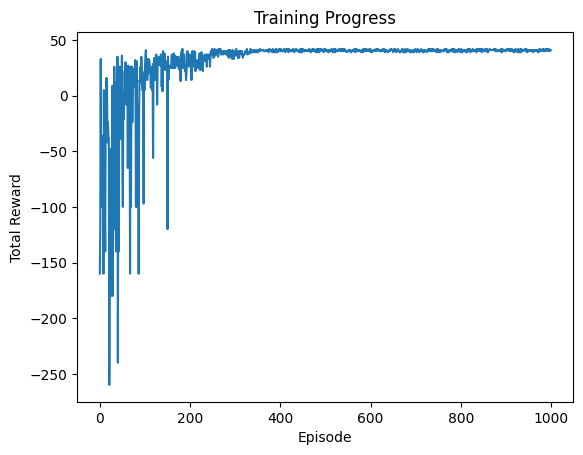

In [ ]:
# Initialize environment and agent
env = MultiAgentEnv(num_agents=1, grid_size=10, obstacle_count=3)
agent = DoubleQLearningAgent(env)

num_episodes = 1000
max_steps = 100
rewards_per_episode = []

for episode in range(num_episodes):
    state, _ = env.reset(seed=42)
    total_reward = 0

    for step in range(max_steps):
        action = agent.select_action(state[0])  # Single-agent

        next_state, reward, terminated, truncated, _ = env.step([action])

        # Update agent
        agent.update(state[0], action, reward, next_state[0], terminated)

        total_reward += reward
        state = next_state

        if terminated or truncated:
            break

    # Decay epsilon
    agent.decay_epsilon()
    rewards_per_episode.append(total_reward)

    print(f"Episode {episode + 1}/{num_episodes} - Total Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")

# Plot rewards
import matplotlib.pyplot as plt
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()


# Running the Optimal Policy for Double Q Learning (Single Agent)

Episode 1/10 - Total Reward: 42.0, Epsilon: 0.100
Episode 2/10 - Total Reward: 42.0, Epsilon: 0.100
Episode 3/10 - Total Reward: 42.0, Epsilon: 0.100
Episode 4/10 - Total Reward: 42.0, Epsilon: 0.100
Episode 5/10 - Total Reward: 42.0, Epsilon: 0.100
Episode 6/10 - Total Reward: 42.0, Epsilon: 0.100
Episode 7/10 - Total Reward: 42.0, Epsilon: 0.100
Episode 8/10 - Total Reward: 42.0, Epsilon: 0.100
Episode 9/10 - Total Reward: 42.0, Epsilon: 0.100
Episode 10/10 - Total Reward: 42.0, Epsilon: 0.100


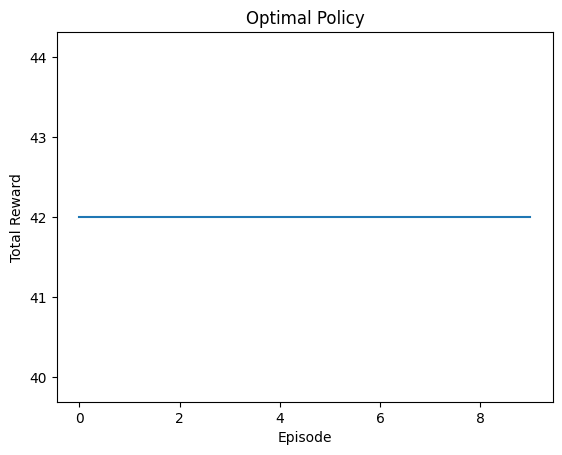

In [ ]:
env = MultiAgentEnv(num_agents=1, grid_size=10, obstacle_count=3)


num_episodes = 10
max_steps = 100
rewards_per_episode = []



for episode in range(num_episodes):
    state, _ = env.reset(seed=42)
    total_reward = 0
    state = state[0]

    for step in range(max_steps):
        combined_q = agent.q1[state[0], state[1], :] + agent.q2[state[0], state[1], :]
        action = np.argmax(combined_q)

        next_state, reward, terminated, truncated, _ = env.step([action])


        total_reward += reward
        state = next_state[0]

        if terminated or truncated:
            break

    # Decay epsilon
    agent.decay_epsilon()
    rewards_per_episode.append(total_reward)

    print(f"Episode {episode + 1}/{num_episodes} - Total Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")

# Plot rewards
import matplotlib.pyplot as plt
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Optimal Policy')
plt.show()

# Double Q Learning Model for Multi Agent Env

In [ ]:
import numpy as np

class DoubleQLearningAgent:
    def __init__(self, num_agents, state_space, action_space, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1):
        self.num_agents = num_agents
        self.state_space = state_space
        self.action_space = action_space
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Initialize two Q-tables for Double Q-Learning
        self.Q1 = [np.zeros((state_space[0], state_space[1], action_space)) for _ in range(num_agents)]
        self.Q2 = [np.zeros((state_space[0], state_space[1], action_space)) for _ in range(num_agents)]

    def get_action(self, state):
        actions = []
        for agent_id, agent_state in enumerate(state):
            if np.random.rand() < self.epsilon:  # Exploration
                action = np.random.choice(self.action_space)
            else:  # Exploitation
                # Combine Q1 and Q2 for action selection
                combined_Q = self.Q1[agent_id][agent_state[0], agent_state[1]] + self.Q2[agent_id][agent_state[0], agent_state[1]]
                action = np.argmax(combined_Q)
            actions.append(action)
        return actions

    def update(self, state, actions, rewards, next_state, terminated):
        for agent_id in range(self.num_agents):
            s = state[agent_id]
            a = actions[agent_id]
            r = rewards/self.num_agents
            s_next = next_state[agent_id]

            if terminated:  # If agent's episode has terminated
                target = r
            else:
                if np.random.rand() < 0.5:
                    # Update Q1
                    a_next = np.argmax(self.Q1[agent_id][s_next[0], s_next[1]])
                    target = r + self.gamma * self.Q2[agent_id][s_next[0], s_next[1], a_next]
                    self.Q1[agent_id][s[0], s[1], a] += self.alpha * (target - self.Q1[agent_id][s[0], s[1], a])
                else:
                    # Update Q2
                    a_next = np.argmax(self.Q2[agent_id][s_next[0], s_next[1]])
                    target = r + self.gamma * self.Q1[agent_id][s_next[0], s_next[1], a_next]
                    self.Q2[agent_id][s[0], s[1], a] += self.alpha * (target - self.Q2[agent_id][s[0], s[1], a])

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Training the Double Q Learning Model

Episode 1/1000, Total Reward: -520.0, Epsilon: 0.606
Episode 2/1000, Total Reward: 210.0, Epsilon: 0.367
Episode 3/1000, Total Reward: 430.0, Epsilon: 0.222
Episode 4/1000, Total Reward: -240.0, Epsilon: 0.135
Episode 5/1000, Total Reward: -200.0, Epsilon: 0.100
Episode 6/1000, Total Reward: -240.0, Epsilon: 0.100
Episode 7/1000, Total Reward: -320.0, Epsilon: 0.100
Episode 8/1000, Total Reward: -280.0, Epsilon: 0.100
Episode 9/1000, Total Reward: 950.0, Epsilon: 0.100
Episode 10/1000, Total Reward: -240.0, Epsilon: 0.100
Episode 11/1000, Total Reward: -230.0, Epsilon: 0.100
Episode 12/1000, Total Reward: -110.0, Epsilon: 0.100
Episode 13/1000, Total Reward: -210.0, Epsilon: 0.100
Episode 14/1000, Total Reward: -400.0, Epsilon: 0.100
Episode 15/1000, Total Reward: -280.0, Epsilon: 0.100
Episode 16/1000, Total Reward: -220.0, Epsilon: 0.100
Episode 17/1000, Total Reward: 1310.0, Epsilon: 0.100
Episode 18/1000, Total Reward: -320.0, Epsilon: 0.100
Episode 19/1000, Total Reward: -280.0, E

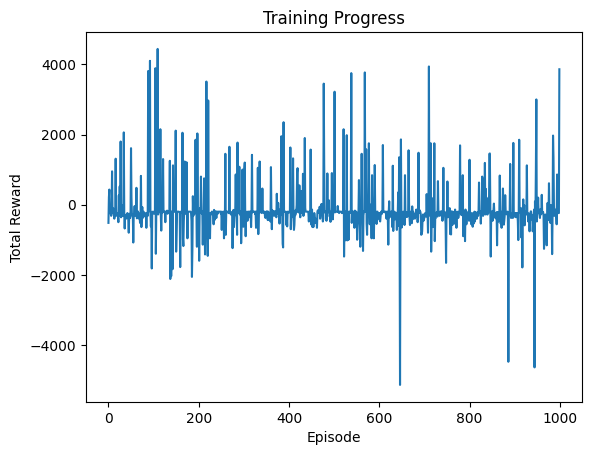

In [ ]:
# Initialize the environment and agent
num_agents = 2
grid_size = 10
obstacle_count = 3
env = MultiAgentEnv(num_agents=num_agents, grid_size=grid_size, obstacle_count=obstacle_count)

state_space = (grid_size, grid_size)  # Grid dimensions for each agent
action_space = 4  # Up, Down, Left, Right
agent = DoubleQLearningAgent(num_agents, state_space, action_space)

# Training parameters
num_episodes = 1000
rewards_per_episode = []
max_steps_per_episode = 100

for episode in range(num_episodes):
    state, info = env.reset(seed=episode)
    state = state.tolist()  # Convert state to list for easier indexing
    total_reward = 0

    for step in range(max_steps_per_episode):
        actions = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(actions)
        next_state = next_state.tolist()  # Convert next_state to list
        total_reward += reward

        # Update Q-tables
        agent.update(state, actions, reward, next_state, terminated)

        state = next_state

        if terminated or truncated:
            break

    rewards_per_episode.append(total_reward)
    # Logging progress
    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")



# Plot rewards
import matplotlib.pyplot as plt
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()

# Save the Q-tables for future use
np.save("Q1_table.npy", agent.Q1)
np.save("Q2_table.npy", agent.Q2)

# Running the Optimal Policy for Double Q Learning (Single Agent)

Episode 1/10, Total Reward: -240.0, Steps: 100
Episode 2/10, Total Reward: -240.0, Steps: 100
Episode 3/10, Total Reward: -240.0, Steps: 100
Episode 4/10, Total Reward: -240.0, Steps: 100
Episode 5/10, Total Reward: -240.0, Steps: 100
Episode 6/10, Total Reward: -240.0, Steps: 100
Episode 7/10, Total Reward: -240.0, Steps: 100
Episode 8/10, Total Reward: -2060.0, Steps: 100
Episode 9/10, Total Reward: -240.0, Steps: 100
Episode 10/10, Total Reward: -240.0, Steps: 100


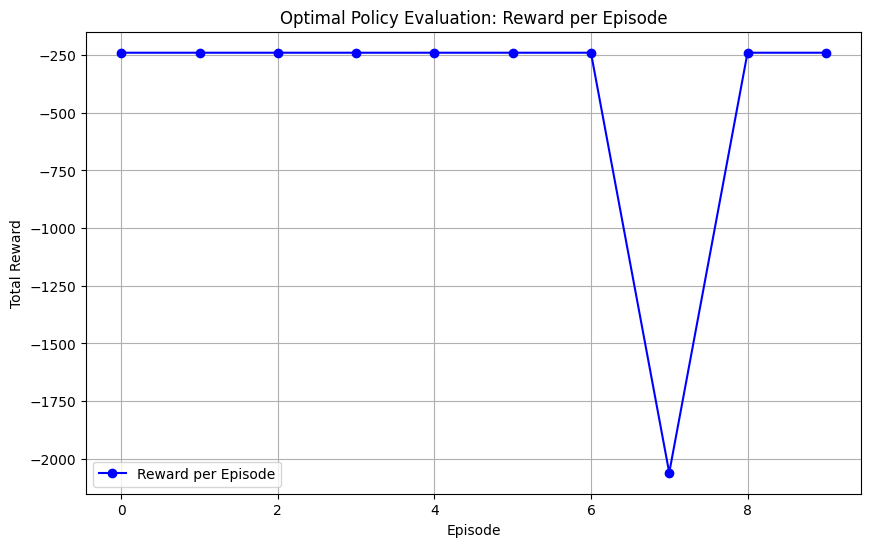

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Modify agent to use optimal policy for evaluation
class DoubleQLearningAgentOptimal(DoubleQLearningAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_action(self, state):
        actions = []
        for agent_id, agent_state in enumerate(state):
            # Always choose the optimal action
            combined_Q = self.Q1[agent_id][agent_state[0], agent_state[1]] + self.Q2[agent_id][agent_state[0], agent_state[1]]
            action = np.argmax(combined_Q)
            actions.append(action)
        return actions

# Load the trained Q-tables
agent_optimal = DoubleQLearningAgentOptimal(num_agents, state_space, action_space)
agent_optimal.Q1 = np.load("Q1_table.npy", allow_pickle=True)
agent_optimal.Q2 = np.load("Q2_table.npy", allow_pickle=True)

# Evaluation parameters
num_eval_episodes = 10
reward_per_episode = []

for episode in range(num_eval_episodes):
    state, info = env.reset(seed=episode)
    state = state.tolist()  # Convert state to list
    total_reward = 0
    done = False
    steps = 0

    while not done:
        actions = agent_optimal.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(actions)
        total_reward += reward
        state = next_state.tolist()
        done = terminated or truncated
        steps += 1

    reward_per_episode.append(total_reward)
    print(f"Episode {episode + 1}/{num_eval_episodes}, Total Reward: {total_reward}, Steps: {steps}")

# Plotting the reward per episode
plt.figure(figsize=(10, 6))
plt.plot(reward_per_episode, marker="o", linestyle="-", color="b", label="Reward per Episode")
plt.title("Optimal Policy Evaluation: Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid()
plt.show()

# Multi Agent PPO Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Neural Networks for Actor and Critic
class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=128):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, act_dim),
            nn.Softmax(dim=-1)  # Output probabilities for actions
        )

    def forward(self, obs):
        return self.net(obs)


class Critic(nn.Module):
    def __init__(self, obs_dim, hidden_dim=128):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Scalar value output
        )

    def forward(self, obs):
        return self.net(obs)


# PPO Algorithm
class MAPPO:
    def __init__(self, env, actor_lr=1e-5, critic_lr=1e-5, gamma=0.99, clip_eps=0.3, entropy_coef=0.008):
        self.env = env
        self.num_agents = env.num_agents
        self.gamma = gamma
        self.clip_eps = clip_eps
        self.entropy_coef = entropy_coef

        # Initialize actors and critics for all agents
        obs_dim = env.observation_space.shape[1] * env.num_agents  # Flattened state for all agents
        act_dim = env.action_space.nvec[0]

        self.actors = [Actor(obs_dim, act_dim) for _ in range(self.num_agents)]
        self.critics = [Critic(obs_dim) for _ in range(self.num_agents)]
        self.actor_optimizers = [optim.Adam(actor.parameters(), lr=actor_lr) for actor in self.actors]
        self.critic_optimizers = [optim.Adam(critic.parameters(), lr=critic_lr) for critic in self.critics]

    def select_actions(self, obs):
        """Select actions for all agents based on their respective policies."""
        actions = []
        log_probs = []
        for i, actor in enumerate(self.actors):
            obs_tensor = torch.tensor(obs.flatten(), dtype=torch.float32).unsqueeze(0)
            probs = actor(obs_tensor)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            actions.append(action.item())
            log_probs.append(dist.log_prob(action).item())
        return np.array(actions), np.array(log_probs)

    def compute_advantages(self, rewards, values, dones):
        """Compute advantages using GAE."""
        advantages = []
        returns = []
        next_value = 0
        gae = 0
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + self.gamma * next_value * (1 - dones[step]) - values[step]
            gae = delta + self.gamma * gae * (1 - dones[step])
            advantages.insert(0, gae)
            next_value = values[step]
        returns = [adv + val for adv, val in zip(advantages, values)]
        return torch.tensor(advantages, dtype=torch.float32), torch.tensor(returns, dtype=torch.float32)

    def train(self, num_episodes=1000, max_steps=100):
        for episode in range(num_episodes):
            obs, _ = self.env.reset()
            obs = np.array(obs).flatten()  # Flatten multi-agent observations
            log_probs, values, rewards, dones = [], [], [], []
            trajectories = {"obs": [], "actions": [], "log_probs": [], "rewards": [], "dones": []}

            # Run a single episode
            for step in range(max_steps):
                actions, action_log_probs = self.select_actions(obs)
                next_obs, reward, terminated, truncated, _ = self.env.step(actions)
                done = terminated or truncated

                # Store trajectories
                trajectories["obs"].append(obs)
                trajectories["actions"].append(actions)
                trajectories["log_probs"].append(action_log_probs)
                trajectories["rewards"].append(reward)
                trajectories["dones"].append(done)

                obs = np.array(next_obs).flatten()
                if done:
                    break

            # Process trajectories
            rewards = trajectories["rewards"]
            dones = trajectories["dones"]
            obs_tensor = torch.tensor(np.array(trajectories["obs"]), dtype=torch.float32)
            actions_tensor = torch.tensor(np.array(trajectories["actions"]), dtype=torch.int64)
            log_probs_tensor = torch.tensor(np.array(trajectories["log_probs"]), dtype=torch.float32)

            # Compute advantages and returns
            for agent_idx in range(self.num_agents):
                critic = self.critics[agent_idx]
                values = critic(obs_tensor).squeeze().detach().numpy()
                advantages, returns = self.compute_advantages(rewards, values, dones)

                # Update policy (actor)
                actor = self.actors[agent_idx]
                old_probs = log_probs_tensor[:, agent_idx]
                for _ in range(4):  # Multiple epochs for PPO
                    probs = actor(obs_tensor).gather(1, actions_tensor[:, agent_idx].unsqueeze(-1)).squeeze()
                    ratio = probs / old_probs
                    clip_adv = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advantages
                    loss_actor = -torch.min(ratio * advantages, clip_adv).mean()
                    loss_entropy = -self.entropy_coef * torch.distributions.Categorical(probs).entropy().mean()
                    self.actor_optimizers[agent_idx].zero_grad()
                    (loss_actor + loss_entropy).backward()
                    self.actor_optimizers[agent_idx].step()

                # Update value function (critic)
                values_pred = critic(obs_tensor).squeeze()
                loss_critic = nn.MSELoss()(values_pred, returns)
                self.critic_optimizers[agent_idx].zero_grad()
                loss_critic.backward()
                self.critic_optimizers[agent_idx].step()

            print(f"Episode {episode + 1}/{num_episodes} completed. Total Reward: {np.sum(rewards)}")



# Training the Multi Agent PPO

Episode 1/500, Total Reward: -320.0
Episode 1/1 completed. Total Reward: -610.0
Episode 2/500, Total Reward: -540.0
Episode 1/1 completed. Total Reward: -380.0
Episode 3/500, Total Reward: -210.0
Episode 1/1 completed. Total Reward: -280.0
Episode 4/500, Total Reward: -560.0
Episode 1/1 completed. Total Reward: -260.0
Episode 5/500, Total Reward: 220.0
Episode 1/1 completed. Total Reward: -340.0
Episode 6/500, Total Reward: -440.0
Episode 1/1 completed. Total Reward: -340.0
Episode 7/500, Total Reward: -400.0
Episode 1/1 completed. Total Reward: -380.0
Episode 8/500, Total Reward: -330.0
Episode 1/1 completed. Total Reward: -500.0
Episode 9/500, Total Reward: -400.0
Episode 1/1 completed. Total Reward: -300.0
Episode 10/500, Total Reward: -150.0
Episode 1/1 completed. Total Reward: -260.0
Episode 11/500, Total Reward: -440.0
Episode 1/1 completed. Total Reward: -400.0
Episode 12/500, Total Reward: -130.0
Episode 1/1 completed. Total Reward: -410.0
Episode 13/500, Total Reward: -430.0
E

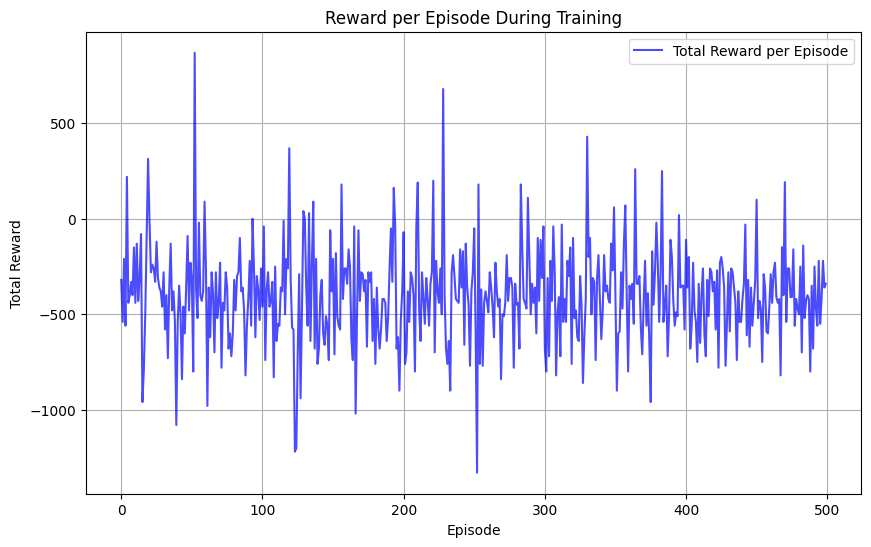

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming MAPPO and MultiAgentEnv are already implemented as described above

# Initialize environment and MAPPO
env = MultiAgentEnv(num_agents=2, grid_size=10, obstacle_count=3)
mappo = MAPPO(env)

# Training parameters
num_episodes = 500
max_steps = 100  # Maximum steps per episode
reward_per_episode = []  # Store total reward per episode

# Training loop
for episode in range(num_episodes):
    obs, _ = env.reset()  # Reset environment
    obs = np.array(obs).flatten()  # Flatten the multi-agent observations
    total_reward = 0

    for step in range(max_steps):
        actions, _ = mappo.select_actions(obs)  # Select actions for all agents
        next_obs, reward, terminated, truncated, _ = env.step(actions)  # Step environment
        total_reward += reward
        done = terminated or truncated
        obs = np.array(next_obs).flatten()

        if done:
            break

    # Append total reward for this episode
    reward_per_episode.append(total_reward)
    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}")

    # Train agents after collecting the episode data
    mappo.train(num_episodes=1, max_steps=max_steps)

# Plot the rewards
plt.figure(figsize=(10, 6))
plt.plot(reward_per_episode, label='Total Reward per Episode', color='blue', alpha=0.7)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode During Training')
plt.legend()
plt.grid(True)
plt.show()


# Running the Optimal Policy

Test Episode 1/10, Total Reward: -200.0
Test Episode 2/10, Total Reward: -200.0
Test Episode 3/10, Total Reward: -200.0
Test Episode 4/10, Total Reward: -200.0
Test Episode 5/10, Total Reward: -150.0
Test Episode 6/10, Total Reward: -200.0
Test Episode 7/10, Total Reward: -2160.0
Test Episode 8/10, Total Reward: -2200.0
Test Episode 9/10, Total Reward: -200.0
Test Episode 10/10, Total Reward: -2040.0


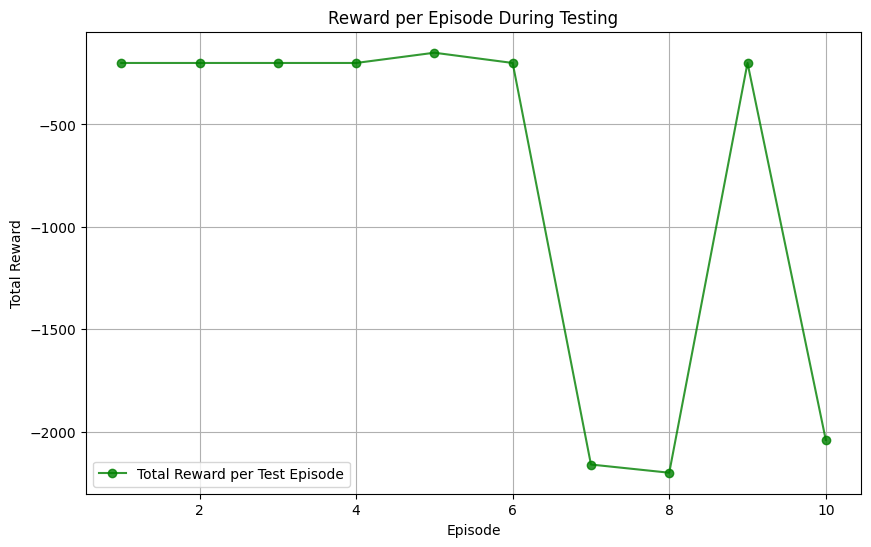

In [ ]:
# Testing parameters
num_test_episodes = 10  # Number of episodes for testing
reward_per_test_episode = []  # Store total reward per episode during testing

# Testing loop
for episode in range(num_test_episodes):
    obs, _ = env.reset()  # Reset environment
    obs = np.array(obs).flatten()  # Flatten the multi-agent observations
    total_reward = 0

    for step in range(max_steps):
        # Select actions based on the optimal policy (deterministic selection)
        actions = []
        for actor in mappo.actors:
            obs_tensor = torch.tensor(obs.flatten(), dtype=torch.float32).unsqueeze(0)
            probs = actor(obs_tensor)
            action = torch.argmax(probs).item()  # Choose action with highest probability
            actions.append(action)

        next_obs, reward, terminated, truncated, _ = env.step(actions)  # Step environment
        total_reward += reward
        done = terminated or truncated
        obs = np.array(next_obs).flatten()

        if done:
            break

    # Append total reward for this episode
    reward_per_test_episode.append(total_reward)
    print(f"Test Episode {episode + 1}/{num_test_episodes}, Total Reward: {total_reward}")

# Plot the rewards
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_test_episodes + 1), reward_per_test_episode, label='Total Reward per Test Episode', color='green', marker='o', alpha=0.8)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode During Testing')
plt.legend()
plt.grid(True)
plt.show()